<h1><center>Modeling Neutronic Transient using Gaussian Processes</center></h1>
<h2><center>Statistics-713 Project</center></h2>

 <h3><center> by Rabab Elzohery</center></h3>

This tutorial gives a brief description of a method proposed to approximate the response of a neutronic transient simulation. The method involves two basic steps. First, a reduction is made in the spatial domain which can be viewed as transformation of the response. Second, A linear statisticl model is used to approximat the response in the lower dimensional space.

The method was explored on two case studies.

### Necessary Imports
Importing required libraries/packages

In [46]:
# Imports 
import matplotlib.pylab as plt
%matplotlib inline
import plot_setting
import numpy as np
import pickle
import time
import warnings
warnings.filterwarnings('ignore')

# sikit-learn imports
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, Matern, RationalQuadratic


# **Method**
* Summary of the procedures
    * Find the $r$ principal components or POD along which the data has maximum varaince via SVD: $Y = U \Sigma V$
    * Decompose the response as follow: $ \textbf{y} = \bar{\textbf{y}}(x) + \sum_{i=1}^r \textbf{u}_i a_i(t) $
    * Transform the responce space to lower dimensional space $ \to \textbf{a(t)} = {\textbf{U}_r}^T \textbf{Y}$
    * Build linear model that approximates $\tilde{\textbf{a(t)}}$
    * Back transfromation to the original space $\textbf{Y} \approx \textbf{U} \tilde{\textbf{a(t)}}$
    


# **Case study 1**
The data used here is coming from a numerical simulation of a simple 1D reactor transient in which neutronic effects only were considered (i.e, there is no multi-physics coupling).
The spatial-temporal neutron flux are the response of interest.  
This case study was intended to serve as a toy problem to explore the potential of different surrogate model to approximate the reactor dynamics.
So, for the same case study, different surrogates were developed using intrusive methods such as POD-Galerkin projection and also equation-free or data-driven method such as Dynamic Mode Decomposition (DMD). 

### Load the data and define some problem specific data


In [47]:
snapshots = np.loadtxt('../data/transient_sanpshots_UQ.txt')
flux = snapshots[:, :700].T
tf = 62 # final time
dt = 0.1 # time step
times = np.arange(0, tf+dt, dt)
Ncells = 350

## compute core power from flux
def power(flux):
    E = 200*1E6*1.6E-19  
    nufiss = np.array([[0.000, 0.003, 0.003, 0.003, 0.003, 0.003, 0.000],
                  [0.000, 0.19, 0.19, 0.19, 0.19, 0.19, 0.000]])

    fiss = np.repeat(nufiss, 50, axis=1)/2.5
    power = E*np.sum(fiss[0]* flux.T[:, :Ncells] + fiss[1]* flux.T[:, Ncells:], axis=1)
    
    return power

power_true = power(flux)
flux.shape

(700, 621)

### plot  the data

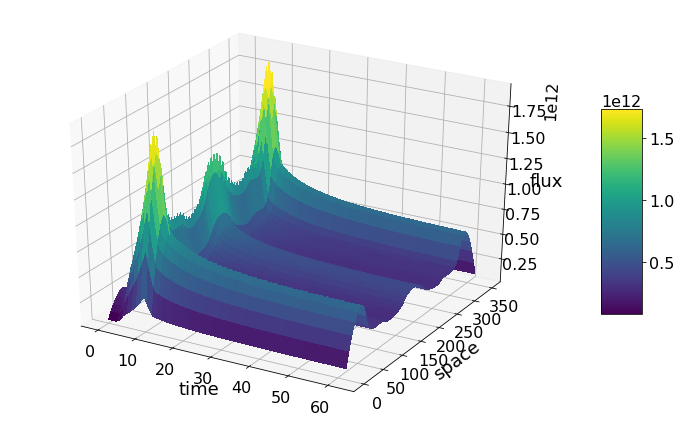

In [48]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
X = times
Y = range(Ncells)
Z = flux[Ncells:, :]
X, Y = np.meshgrid(X, Y)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.set_xlabel('time')
ax.set_ylabel('space')
ax.set_zlabel('flux')


surf = ax.plot_surface(X, Y, Z, cmap='viridis',linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Spatial averaged flux

Text(0, 0.5, 'Flux')

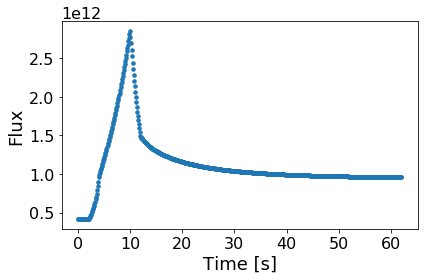

In [49]:
plt.plot(times, np.mean(flux, axis=0), '.')
plt.xlabel('Time [s]')
plt.ylabel('Flux')

## **Potential for Reduction**
A sinuglar value decomposition is performed to explore the potential of data for reduction

Text(0, 0.5, 'singular values')

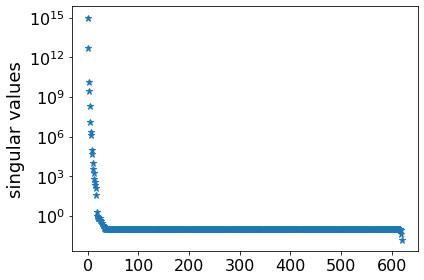

In [50]:
U, S, V = np.linalg.svd(flux)
plt.semilogy(S, '*')
plt.ylabel('singular values')


### Plot data correlation
This a plot of the correlation between the spatial flux. It is clear that there is a strong correlation which
suggests that a reduction can be made.


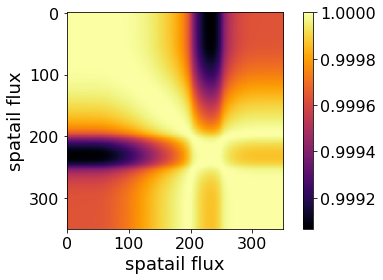

In [51]:
plt.imshow(np.corrcoef(flux[Ncells:, :]), cmap='inferno')
plt.xlabel('spatail flux')
plt.ylabel('spatail flux')

plt.colorbar()

### Generate and plot the expansion coefficents $\textbf{a}(t)$
 20 principal components are retained and they explain almost 99% of the data variance.

In [52]:
r = 20
print(sum(S[:r])/sum(S))

Ur = U[:, :r]
a = Ur.T@flux

0.9999999999999214


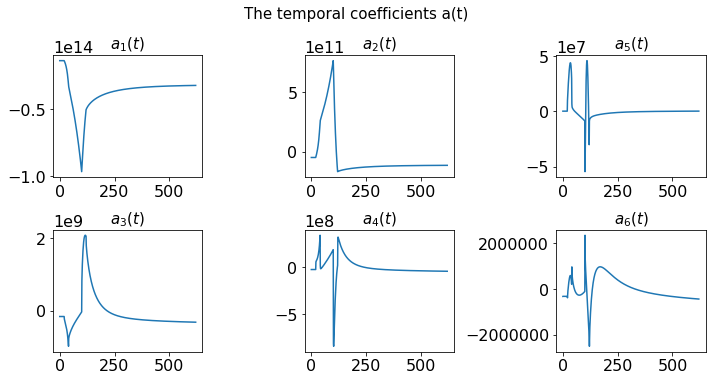

In [53]:
fig, axs = plt.subplots(2, 3, squeeze=False, figsize=(10,5))
fig.suptitle('The temporal coefficients a(t)', size=15, y=1.05)
axs[0, 0].plot(a[0, :])
axs[0, 0].set_title('$a_1(t)$',size = 15)

axs[0, 1].plot(a[1, :])
axs[0, 1].set_title('$a_2(t)$',size = 15)

axs[1, 0].plot(a[2, :])
axs[1, 0].set_title('$a_3(t)$',size = 15)

axs[1, 1].plot(a[3, :])
axs[1, 1].set_title('$a_4(t)$',size = 15)

axs[0, 2].plot(a[4, :])
axs[0, 2].set_title('$a_5(t)$',size = 15)

axs[1, 2].plot(a[5, :])
axs[1, 2].set_title('$a_6(t)$',size = 15)
fig.tight_layout() 


## **General Linear Model - Guassian Process**
* Guassian Process models are characteriaed by:
    * Trand function, represented the mean
    * Correlation function 
  
The linear model with the following form:

$ Y \sim \mathcal{N} (\boldsymbol{\mu}, \textbf{K} + \sigma^2I)$

$\textbf{K}$ is called kernel or correlation functions. Different options can be used for $\textbf{K}$, some of them are explored in the next sections.


#### **Guassian Processes model with different Kernels**

Here, guassian processes model with different kernels is fitted

In [54]:
X = np.arange(0, 62.1, 0.1).reshape(-1, 1)
kernel_1 = C(1, (0.01, 10.0))
kernel_2 = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
kernel_3 = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
kernel_4 = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0))
kernel_5 =  1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)

kernels = [kernel_1, kernel_2 ,kernel_3, kernel_4, kernel_5]

names = ['Constant', 'RBF', 'Marten', 'ExpSineSquared', 'RationalQuadratic']

a_predict = np.zeros(a.shape)
a_prior = np.zeros(a.shape)
a_sigma = np.zeros(a.shape)
models = []
a_preds = []
for i in range(len(kernels)):
    print("Running GP model with {} kernel .....".format(names[i]))
    gp = GaussianProcessRegressor(kernel=kernels[i], n_restarts_optimizer=9, normalize_y=True, optimizer='fmin_l_bfgs_b')
    gp.fit(X, a.T)
    models.append(gp)
    a_pred, sigma = gp.predict(X, return_std=True, return_cov=False)
    a_preds.append(a_pred)

Running GP model with Constant kernel .....
Running GP model with RBF kernel .....
Running GP model with Marten kernel .....
Running GP model with ExpSineSquared kernel .....
Running GP model with RationalQuadratic kernel .....


### Plot the residual of each model

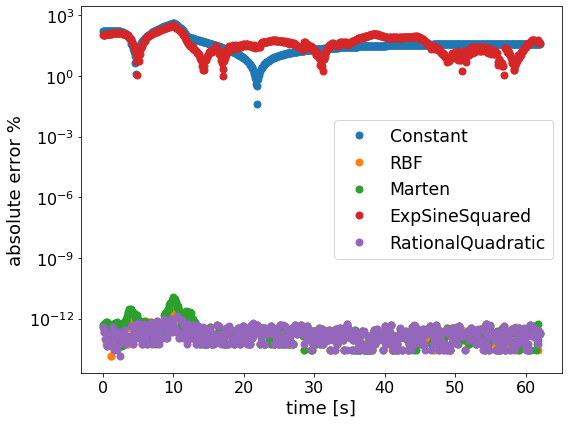

In [44]:
plt.figure(figsize=(8, 6))
for i in range(len(kernels)):
    flux_pred = Ur@a_preds[i].T
    power_pred_one_basis = power(flux_pred)
    errors_power_guassian_proc_one_basis = abs(power_true - power_pred_one_basis)
    plt.semilogy(times, errors_power_guassian_proc_one_basis.squeeze(), 'o')
    plt.xlabel('time [s]')
    plt.ylabel('absolute error %')
    plt.legend(names)
plt.savefig("../Report/figs/gp_kernels.png")

# **Case Study 2:  Getting more complicated**
Here, a more complicated, yet more realistic, problem is studeid. The problem is well known benchmark in the nuclear community known as the the LRA Benchmark. It is a 2D problem and multiphysics coupling is accounted for.    
The data used here is the reactor power at diffrent times during the transient.

### Load the data and define some problem specific data

In [26]:
import scipy as sp

kappa = 3.204e-11
LRA_data = pickle.load(open('../data/diffusion2x2_ref_with_mesh_temps.p', 'rb'), encoding='latin')
t = np.array(LRA_data['times'])   # time
mp = np.array(LRA_data['meshpower']).T # mesh-dependent powers
mp = mp * kappa
p = np.array(LRA_data['power'])# total power
c = p[0]/sp.sum(mp,axis=0)[0] # use to reconstruct power from mesh power
fuel_idx = mp[:, 0]>0                  # pick out fuel mesh
tmp_reduced = mp[fuel_idx, :] # extract fuel data
tmp_full = 0*mp[:, :]  # initialize full data

### Plot the data

Text(0, 0.5, 'power (W/cm$^3$)')

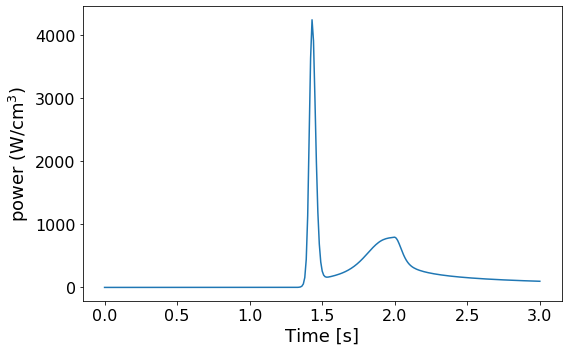

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(t, p)
plt.xlabel('Time [s]')
plt.ylabel("power (W/cm$^3$)")

### Reduction and transformation

In [30]:
# compute temporal coefficient
U, S, V = np.linalg.svd(tmp_reduced)
r = 20
Ur = U[:, :r]

a = Ur.T@tmp_reduced
a_predict = np.zeros(a.shape)
print(sum(S[:r])/sum(S))

0.9999999968395425


### Fit a general linear model
    same as in the first case study

In [31]:
errs  = []

for i in range(len(kernels)):
    print("Running GP model with {} kernel .....".format(names[i]))
    gp = GaussianProcessRegressor(kernel=kernels[i], n_restarts_optimizer=9)
    X = t.reshape(-1, 1)
    y = a.copy()
    gp.fit(X, y.T)

    a_pred, sigma = gp.predict(X, return_std=True)
 
    tmp_reduced_pred = Ur@a_pred.T
    tmp_full[fuel_idx] = tmp_reduced_pred

    p_pred = c*sp.sum(tmp_full, axis=0)

    errs.append(abs(p - p_pred) *100)

Running GP model with Constant kernel .....
Running GP model with RBF kernel .....
Running GP model with Marten kernel .....
Running GP model with ExpSineSquared kernel .....
Running GP model with RationalQuadratic kernel .....


### Plot the results

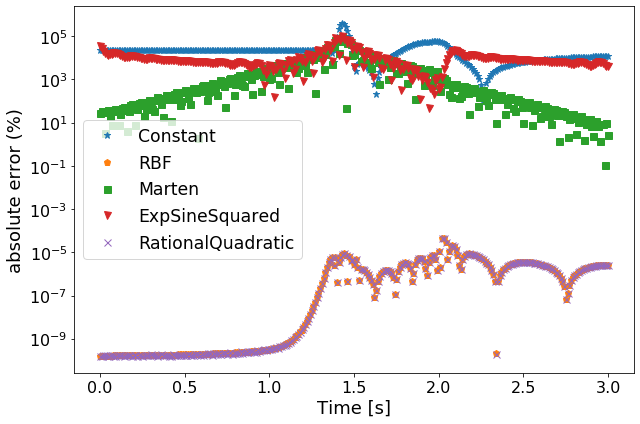

In [33]:
markers = ['*', 'p', 's', 'v', 'x']
fig = plt.figure(figsize=(9, 6))
for i in range(len(errs)):
   plt.semilogy(t, errs[i], markers[i])
plt.legend(names)
plt.xlabel('Time [s]')
plt.ylabel("absolute error (%)")
plt.savefig("../Report/figs/LRA_errs.png")